# Imports

In [5]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [6]:
import os
import glob
import json
import ast
import re

from typing import Dict, List

from src.utils.parsers.cv_parser import fmt_cv_results
from src.utils.visualizers.prediction_figures import PredictionFigures
from src.utils.visualizers.test_figures import TestFigures
from src.utils.visualizers.cv_figures import CVFigures

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Utils

In [7]:
def get_metabolite_info():
    metabolite_data = pd.read_csv('./data/training/metabolites.txt', delimiter='\t')
    raw_metabolites = pd.read_csv('./data/training/metabolites_dataset.data_prep.tsv', delimiter='\t')

    return raw_metabolites.merge(
        metabolite_data, 
        left_on='official_name', right_on='met_name'
    )[['metabolite_id', 'official_name', 'kegg_id', 'pathway', 'method', 'Order']].drop_duplicates().set_index('metabolite_id')

def gather_results(paths: List[str]):
    metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
    df = pd.concat([
        pd.read_csv(path).assign(metabolite_id=metabolite_name) 
        for path, metabolite_name in zip(paths, metabolites_names)
    ])
    return df

def combine_metabolite_info(df):
    metabolite_info = get_metabolite_info()
    df = df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
    return df

In [8]:
metabolite_info = get_metabolite_info()

# Experiments

## Experiment base (TIER0)

In [9]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0"

test_df_all, test_df_metabolite = None, None
if os.path.exists(f'{dir}/best_model_performance_Strategy.ALL.csv'):
    test_df_all = pd.read_csv(
        f'{dir}/best_model_performance_Strategy.ALL.csv',
        index_col=0
    )
    test_df_all = test_df_all.stack().to_frame().reset_index(1).set_axis(['metabolite_arch', 'r2'], axis=1)
    test_df_all[['metabolite_id', 'architecture']] = test_df_all['metabolite_arch'].str.split("_", expand=True)
    test_df_all = test_df_all.drop('metabolite_arch', axis=1).merge(metabolite_info, left_on='metabolite_id', right_index=True).assign(strategy='all')

if os.path.exists(f'{dir}/best_model_performance_Strategy.METABOLITE_CENTRIC.csv'):
    test_df_metabolite = pd.read_csv(
        f'{dir}/best_model_performance_Strategy.METABOLITE_CENTRIC.csv',
        index_col=0
    )
    test_df_metabolite = test_df_metabolite.stack().to_frame().reset_index(1).set_axis(['metabolite_arch', 'r2'], axis=1)
    test_df_metabolite[['metabolite_id', 'architecture']] = test_df_metabolite['metabolite_arch'].str.split("_", expand=True)
    test_df_metabolite = test_df_metabolite.drop('metabolite_arch', axis=1).merge(metabolite_info, left_on='metabolite_id', right_index=True).assign(strategy='metabolite')

if os.path.exists(f'{dir}/best_model_performance_Strategy.ONE_VS_ALL.csv'):
    test_df_one_vs_all = pd.read_csv(
        f'{dir}/best_model_performance_Strategy.ONE_VS_ALL.csv',
        index_col=0
    )
    test_df_one_vs_all = test_df_one_vs_all.stack().to_frame().reset_index(1).set_axis(['metabolite_arch', 'r2'], axis=1)
    test_df_one_vs_all[['metabolite_id', 'architecture']] = test_df_one_vs_all['metabolite_arch'].str.split("_", expand=True)
    test_df_one_vs_all = test_df_one_vs_all.drop('metabolite_arch', axis=1).merge(metabolite_info, left_on='metabolite_id', right_index=True).assign(strategy='one_vs_all')
    # test_df_metabolite = test_df_metabolite.merge(metabolite_info, left_on='metabolite_id', right_index=True).assign(strategy='metabolite')

test_df = pd.concat([test_df_all, test_df_metabolite, test_df_one_vs_all], axis=0)
test_df = test_df[test_df['architecture'] == 'all']
test_figures = TestFigures(test_df)

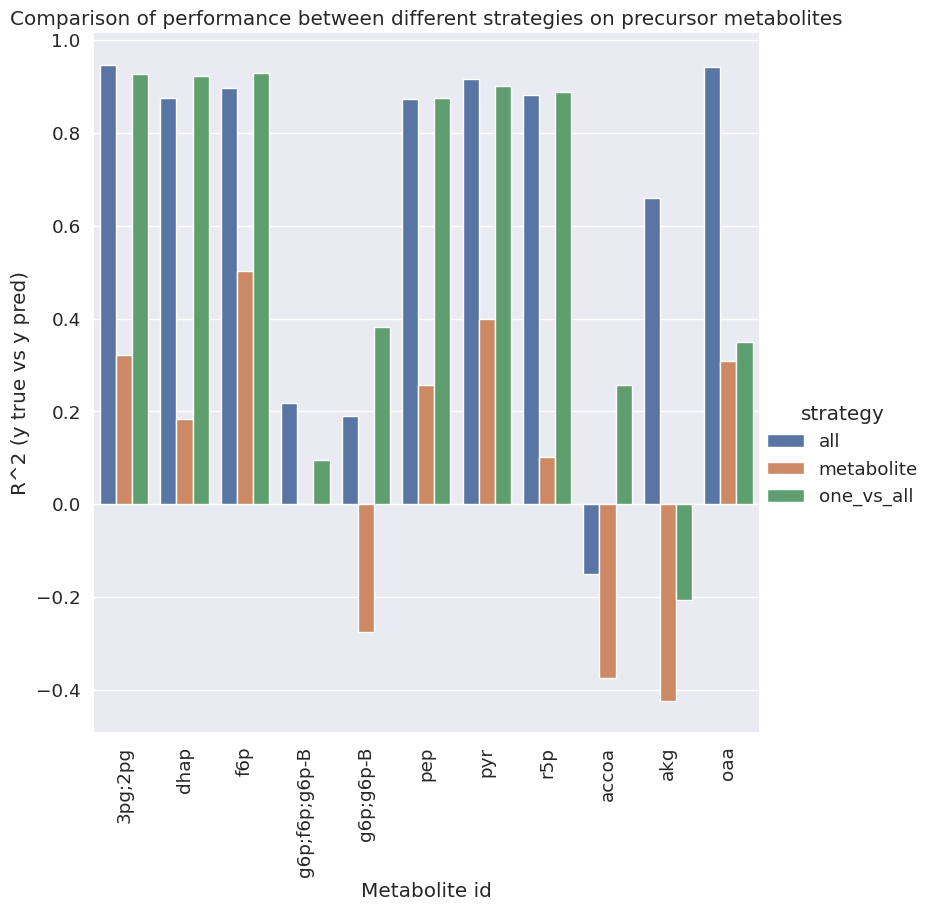

In [12]:
g = test_figures.r2_per_tier(plot_args=dict(height=8))
g.set(
    title='Comparison of performance between different strategies on precursor metabolites',
    xlabel='Metabolite id',
    ylabel="R^2 (y true vs y pred)"
)

# plt.tight_layout()
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.png', bbox_inches='tight')
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.svg', bbox_inches='tight')

### Strategy all

In [94]:
def gather_results_throttle_v2(paths: List[str]):
    throttle_coefficients = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('best_model_performance_Strategy.ALL_throttle').split("__") for path in paths]
    throttle_list = [(throttle, run_id.strip("run")) for throttle, run_id in throttle_coefficients]

    df = pd.concat([
        pd.read_csv(path, index_col=0).stack().to_frame().reset_index(1).set_axis(['metabolite_arch', 'r2'], axis=1).assign(throttle=throttle).assign(run_id=run_id).tail(-1)
        for path, (throttle, run_id) in zip(paths, throttle_list)
    ])

    df[['metabolite_id', 'architecture']] = df['metabolite_arch'].str.split("_", expand=True)
    df = df.drop('metabolite_arch', axis=1)
    return df

In [95]:
dir = "./data/results/experiment_0"

test_pred_df = pd.read_json(
    f'{dir}/best_model_prediction_performance_Strategy.ALL.json'
)
test_pred_df = test_pred_df.T.reset_index().drop("index", axis=1).set_axis(['y_true', 'y_pred', 'architecture', 'metabolite_id', 'correlation'], axis=1) \
    .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
    .explode(['y_true', 'y_pred'])

if len(glob.glob(dir + "/throttle/best_model*Strategy.ALL*_run*.csv")) > 0:
    test_throttle_df = gather_results_throttle_v2(glob.glob(dir + "/throttle/best_model*Strategy.ALL*_run*.csv"))
    test_throttle_df = test_throttle_df.sort_values('throttle').merge(metabolite_info, left_on='metabolite_id', right_index=True).reset_index().drop('index', axis=1)
# test_throttle_df.reset_index().drop('index', axis=1)

explanation_df = pd.read_json(f'{dir}/explanations/Strategy.ALL_explanation.json').merge(metabolite_info, left_on='metabolite_id', right_index=True)

#### Model analysis
1. We analyse per model type what their variance is

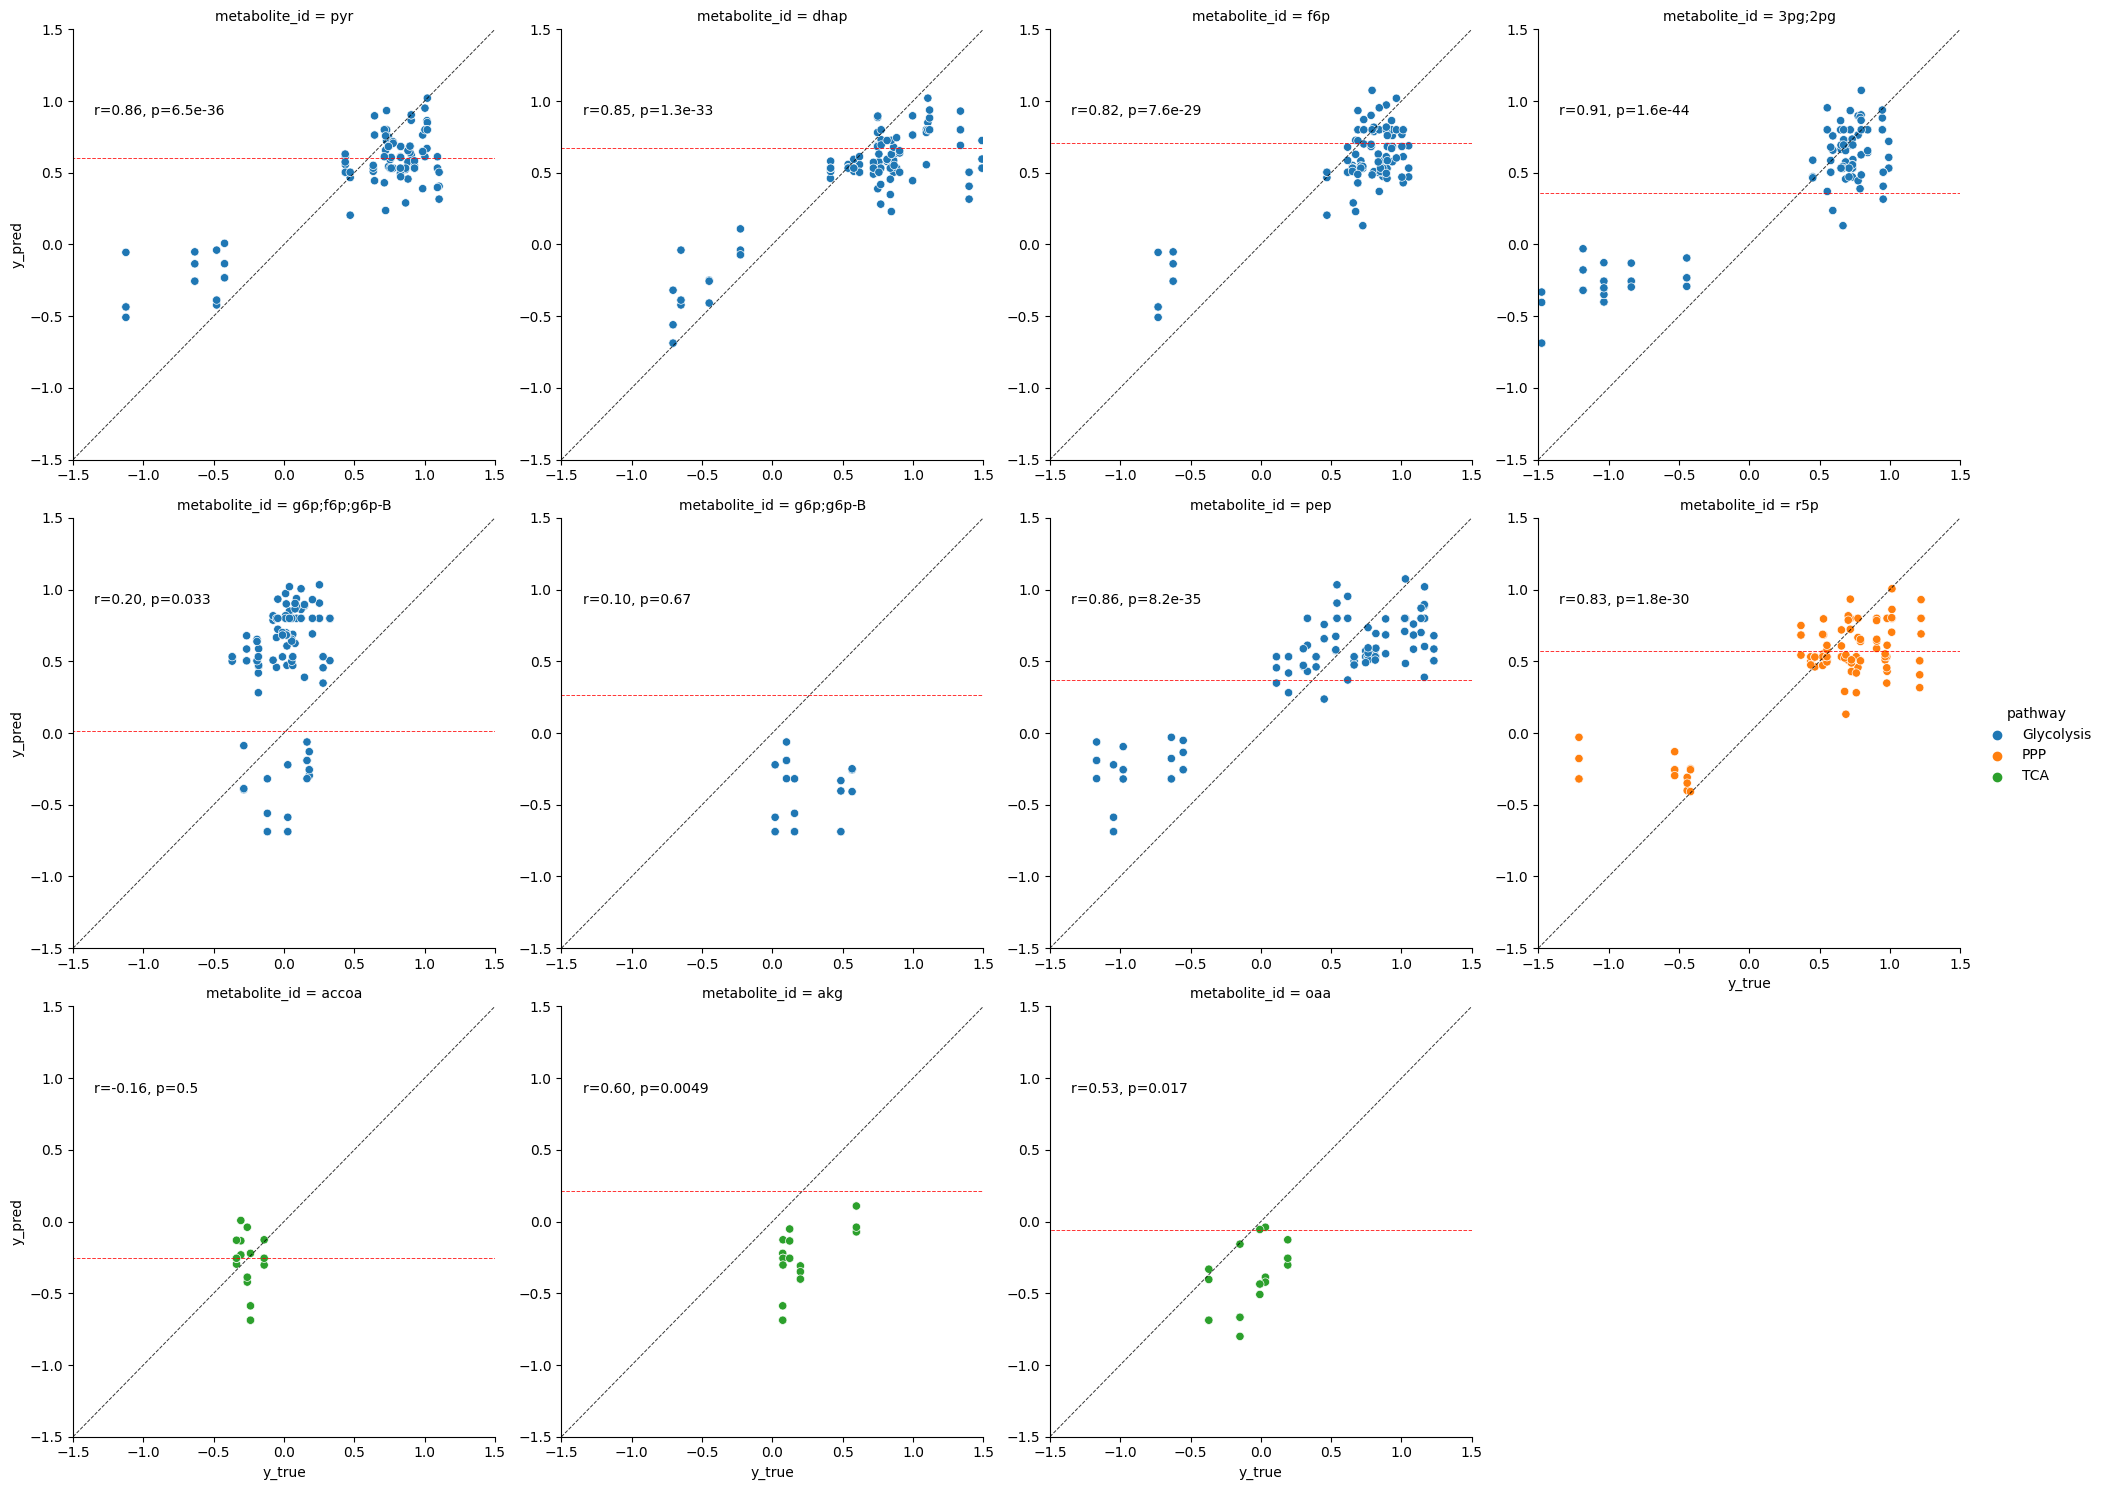

In [34]:
pred_figures = PredictionFigures(test_pred_df)
test_figures = TestFigures(test_df)

pred_figures.prediction_per_metabolite_individual()

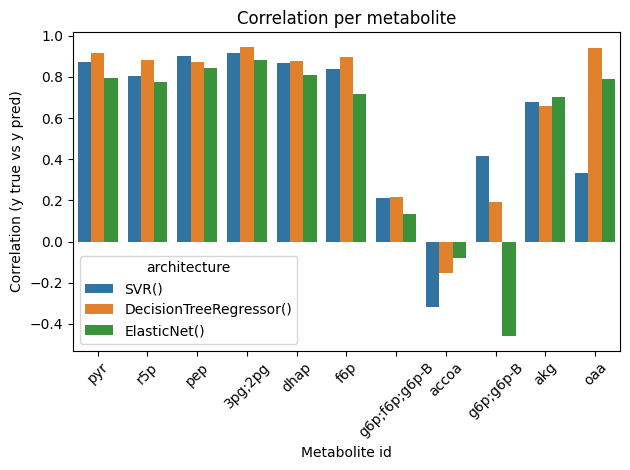

In [35]:
_df = test_pred_df[test_pred_df['architecture'] != 'all']

g = sns.barplot(
    data=_df,
    x='metabolite_id',
    y='correlation',
    hue='architecture'
)
g.axes.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Correlation (y true vs y pred)", title="Correlation per metabolite")
plt.tight_layout()
plt.savefig('./images/correlation_per_metabolite_model_architectures_specific.svg')

/tmp/ipykernel_409/1928314537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['error'] = mean_absolute_error(_df['y_true'].values.reshape(1, -1), _df['y_pred'].values.reshape(1, -1), multioutput='raw_values')
/tmp/ipykernel_409/1928314537.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['mre_error'] = mean_absolute_percentage_error(_df['y_true'].values.reshape(1, -1), _df['y_pred'].values.reshape(1, -1), multioutput='raw_values')


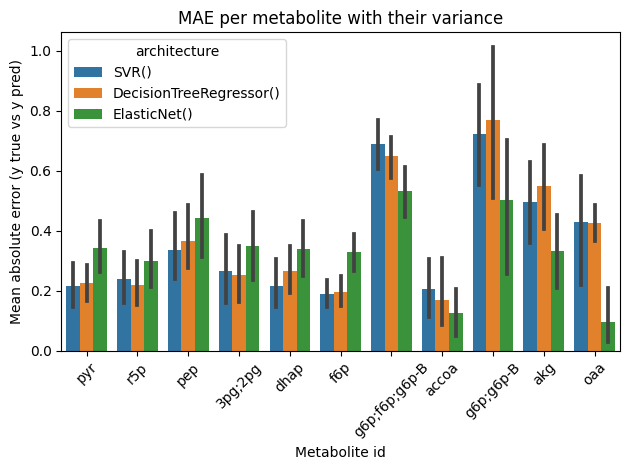

In [36]:
_df = test_pred_df[test_pred_df['architecture'] != 'all']
_df['error'] = mean_absolute_error(_df['y_true'].values.reshape(1, -1), _df['y_pred'].values.reshape(1, -1), multioutput='raw_values')
_df['mre_error'] = mean_absolute_percentage_error(_df['y_true'].values.reshape(1, -1), _df['y_pred'].values.reshape(1, -1), multioutput='raw_values')

g = sns.barplot(
    data=_df,
    x='metabolite_id',
    y='error',
    hue='architecture'
)
g.axes.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Mean absolute error (y true vs y pred)", title="MAE per metabolite with their variance")
plt.tight_layout()
plt.savefig('./images/performance/mae_per_metabolite_model_architectures_specific.svg')
plt.savefig('./images/performance/mae_per_metabolite_model_architectures_specific.png')

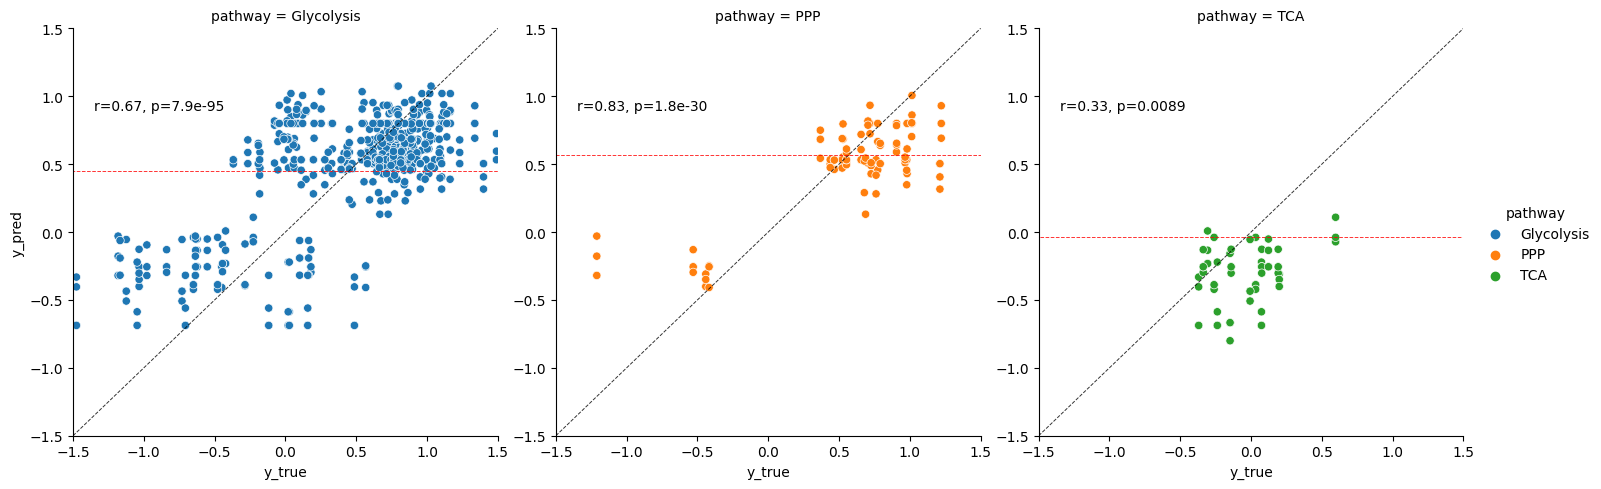

In [37]:
pred_figures.prediction_per_pathway_individual()

plt.savefig('./images/performance/correlation_per_pathway.svg')
plt.savefig('./images/performance/correlation_per_pathway.png')

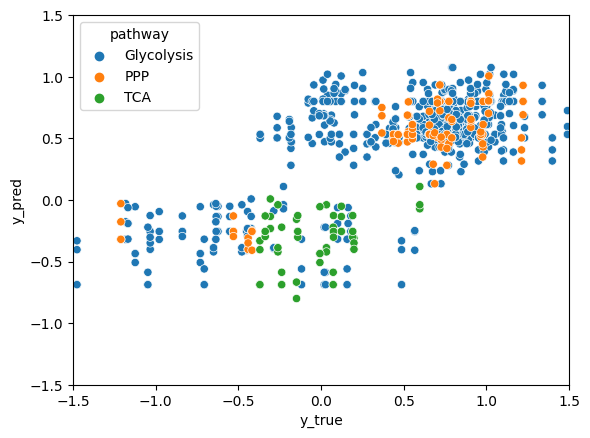

In [38]:
pred_figures.prediction_per_pathway_all()

#### Explanation analysis
1. How many different enzymes are found important per metabolites/pathway
2. Is there a relationship within a metabolite between the different explenations
3. Do we need to account for exp weight

In [39]:
explanation_df

,KO_ORF,metabolite_id,exp_enzymes,exp_weights,y_true,y_pred,official_name,kegg_id,pathway,method,Order
0,YKL116C,pyr,"[YDR272W, YNL134C, YLR351C, YLR044C, YOR362C, ...","[0.1274858533, -0.11766862480000001, 0.0431642...",0.629276,0.865119,Pyruvate,C00022,Glycolysis,TCA,8
1,YBR097W,pyr,"[YNL134C, YDR272W, YHR068W, YOR027W, YOR303W, ...","[-0.1240974823, 0.1196388993, -0.0842184744, -...",-0.452549,-0.422620,Pyruvate,C00022,Glycolysis,TCA,8
4,YOR267C,pyr,"[YDR272W, YHR068W, YLR044C, YML126C, YEL051W, ...","[0.1306051064, -0.0936269299, -0.0439691843, -...",-0.452549,-1.124124,Pyruvate,C00022,Glycolysis,TCA,8
15,YLR248W,pyr,"[YDR272W, YNL134C, YHR068W, YOR027W, YPL131W, ...","[0.13599187640000002, -0.1210893485, -0.085332...",0.629276,0.464969,Pyruvate,C00022,Glycolysis,TCA,8
27,YJL057C,pyr,"[YDR272W, YNL134C, YHR068W, YLR044C, YBR221C, ...","[0.1348411827, -0.11583328990000001, -0.091219...",0.629276,0.424999,Pyruvate,C00022,Glycolysis,TCA,8
...,...,...,...,...,...,...,...,...,...,...,...
93,YOR267C,oaa,"[YDR272W, YHR068W, YIR034C, YGR094W, YPL160W, ...","[0.1310389492, -0.0920429542, -0.0176765458000...",-0.452549,-0.006942,Oxaloacetate,C00036,TCA,TCA,8
144,YHR079C,oaa,"[YNL134C, YDR272W, YHR068W, YPL131W, YOR362C, ...","[-0.1264395224, 0.12455026990000001, -0.088872...",-0.580703,0.029677,Oxaloacetate,C00036,TCA,TCA,8
182,YDR477W,oaa,"[YDR272W, YNL134C, YHR068W, YPL131W, YOR230W, ...","[0.12942750860000002, -0.1232616599, -0.086300...",-0.301374,0.160076,Oxaloacetate,C00036,TCA,TCA,8
192,YNL298W,oaa,"[YNL134C, YDR272W, YHR068W, YPL131W, YLR044C, ...","[-0.12330940030000001, 0.11901198610000001, -0...",-0.290141,-0.053197,Oxaloacetate,C00036,TCA,TCA,8


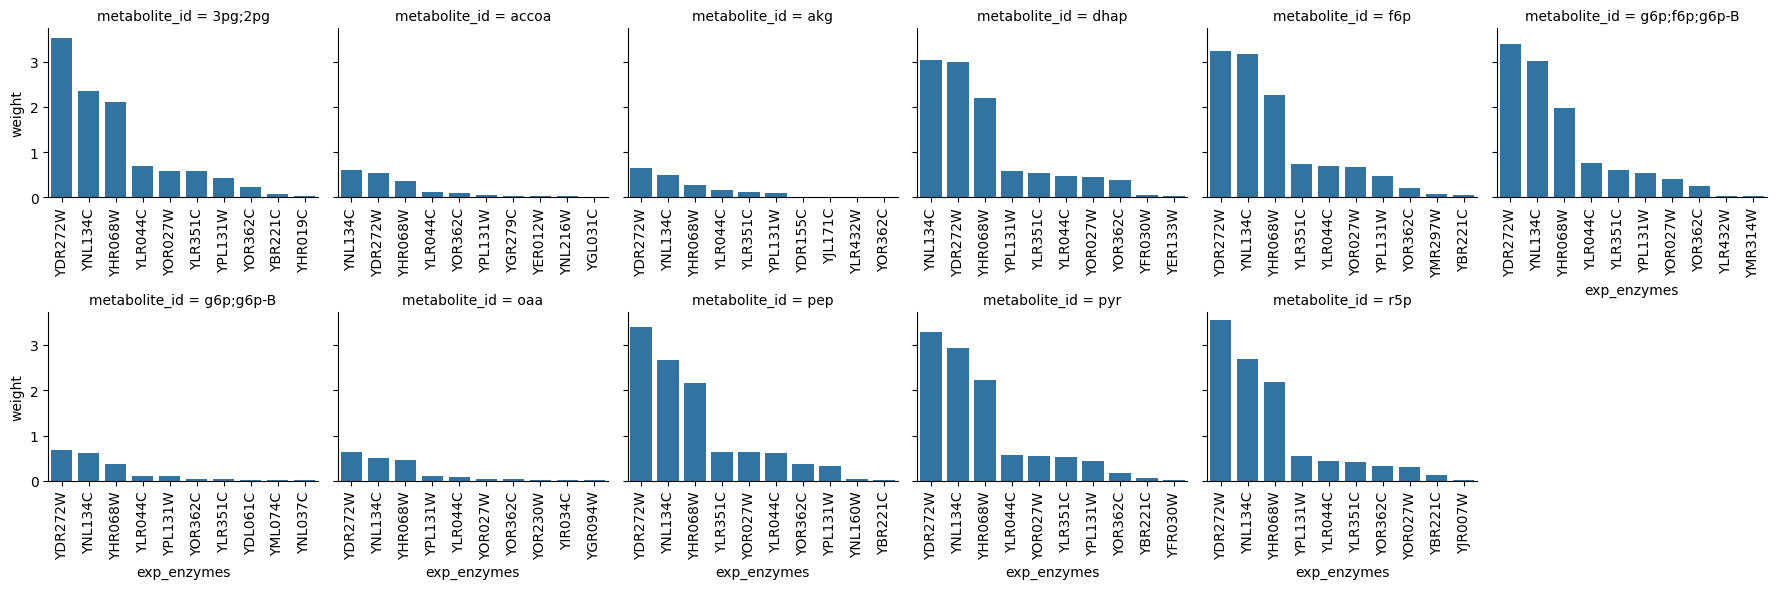

In [40]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights']).groupby(by=['metabolite_id', 'exp_enzymes'])['exp_weights'].sum().abs() \
    .to_frame('weight').reset_index() \
    .groupby('metabolite_id').apply(lambda x: x.sort_values(by='weight', ascending=False).head(10))

g = sns.FacetGrid(data=_df, col='metabolite_id', col_wrap=6, sharex=False)
g.map_dataframe(sns.barplot, x='exp_enzymes', y='weight')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

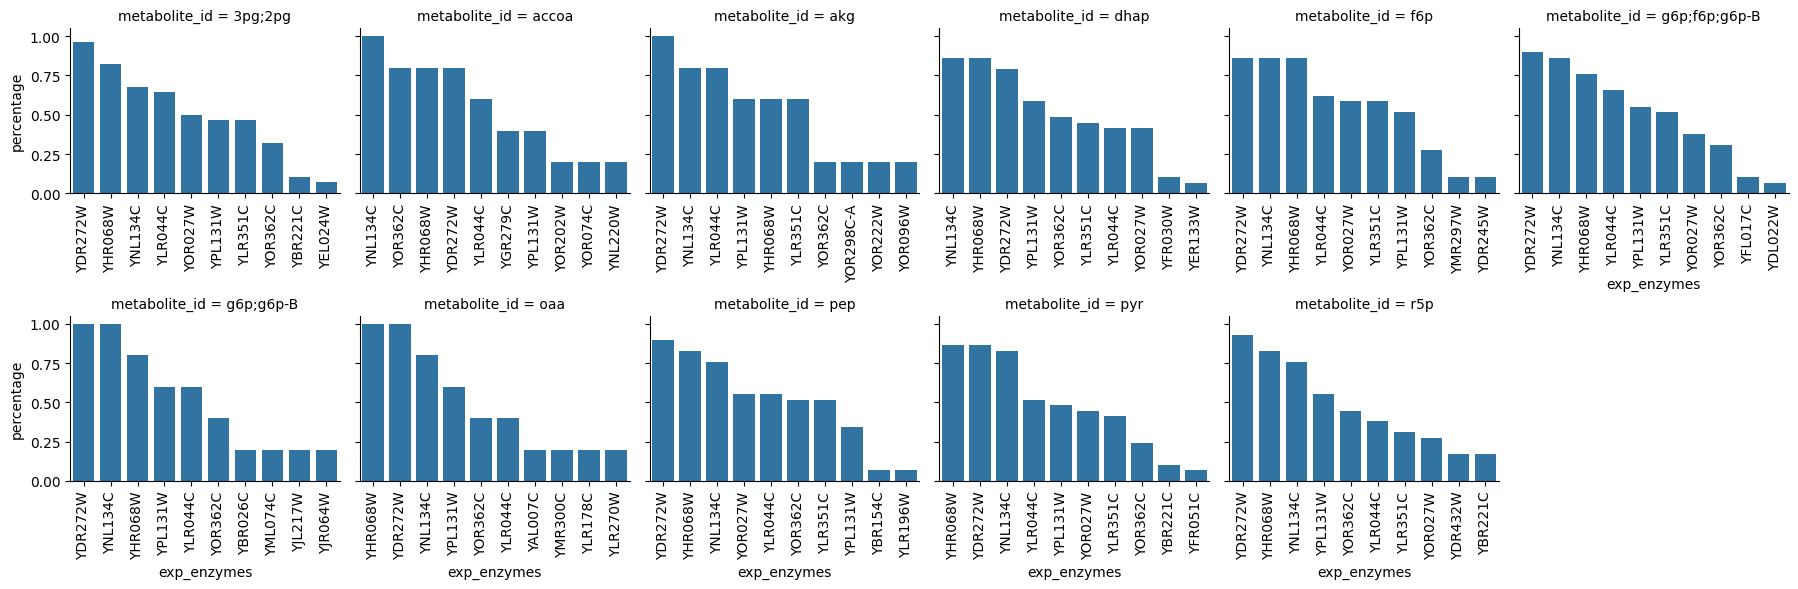

In [41]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights']) \
    .groupby(['metabolite_id', 'exp_enzymes'])['KO_ORF'].count().to_frame('count').reset_index() \
    .groupby('metabolite_id', as_index=False).apply(lambda x: x.sort_values(by='count', ascending=False).head(10)) \
    
_df = _df.merge(
    right=explanation_df.groupby('metabolite_id').size().to_frame('total'),
    left_on='metabolite_id',
    right_on='metabolite_id'
)
_df['percentage'] = _df['count'] / _df['total']

g = sns.FacetGrid(data=_df, col='metabolite_id', col_wrap=6, sharex=False, sharey=True)
g.map_dataframe(sns.barplot, x='exp_enzymes', y='percentage')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

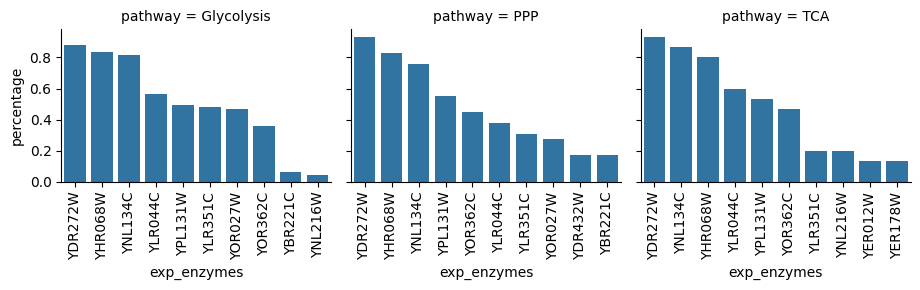

In [42]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights']) \
    .groupby(['pathway', 'exp_enzymes'])['KO_ORF'].count().to_frame('count').reset_index() \
    .groupby('pathway', as_index=False).apply(lambda x: x.sort_values(by='count', ascending=False).head(10)) \
    
_df = _df.merge(
    right=explanation_df.groupby('pathway').size().to_frame('total'),
    left_on='pathway',
    right_on='pathway'
)
_df['percentage'] = _df['count'] / _df['total']

g = sns.FacetGrid(data=_df, col='pathway', col_wrap=6, sharex=False, sharey=True)
g.map_dataframe(sns.barplot, x='exp_enzymes', y='percentage')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

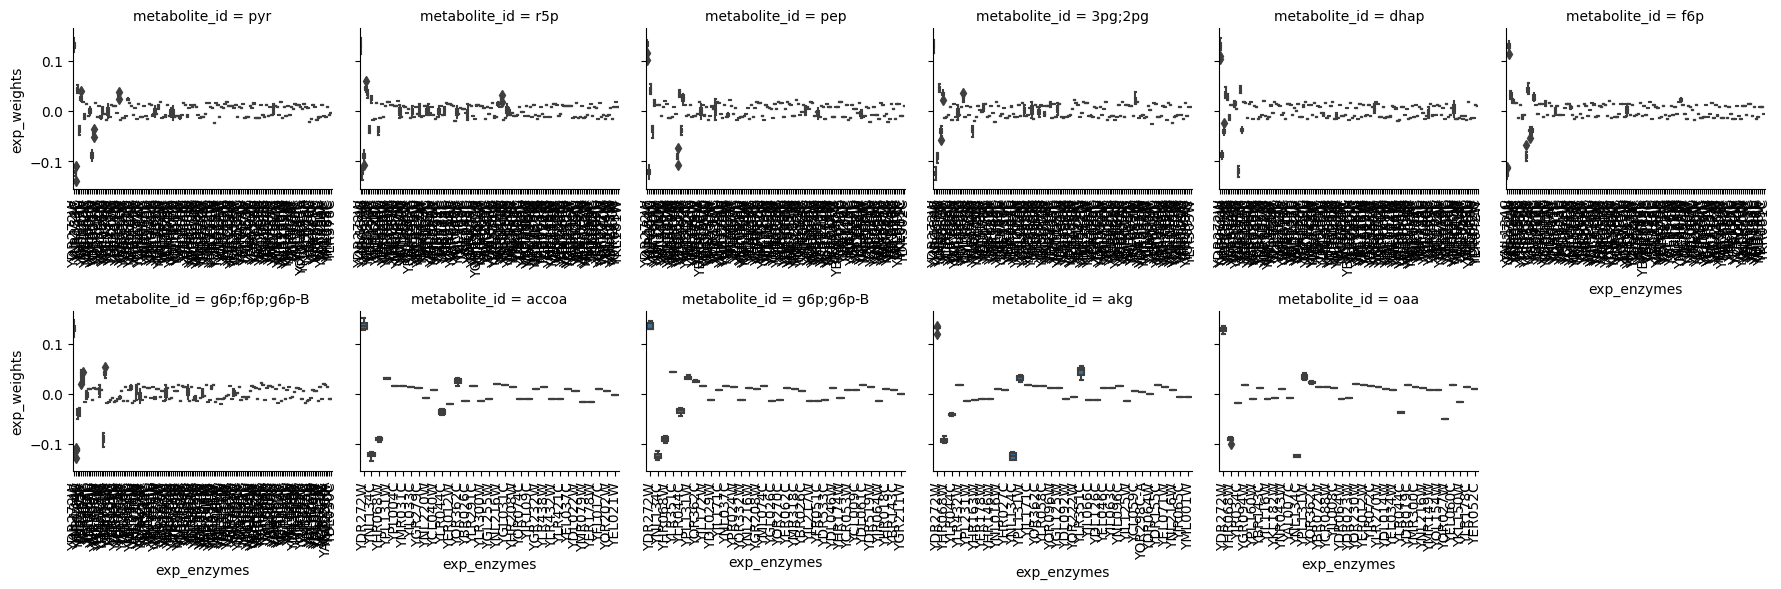

In [43]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights']) 

g = sns.FacetGrid(data=_df, col='metabolite_id', col_wrap=6, sharex=False)
g.map_dataframe(sns.boxplot, x='exp_enzymes', y='exp_weights')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

<AxesSubplot:xlabel='y_true', ylabel='y_pred'>

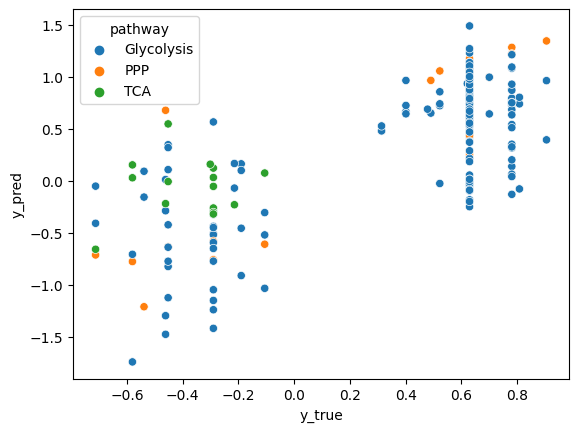

In [44]:
sns.scatterplot(
    data=explanation_df,
    x='y_true',
    y='y_pred',
    hue='pathway',
)

<AxesSubplot:xlabel='exp_enzymes', ylabel='count'>

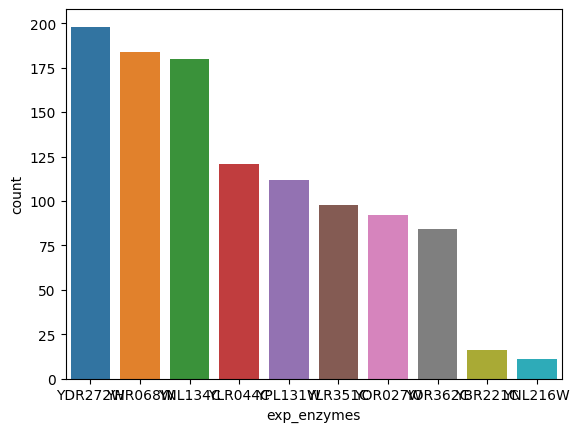

In [45]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights'])
sns.countplot(
    data=_df,
    x='exp_enzymes',
    order=_df['exp_enzymes'].value_counts().iloc[:10].index
)

#### Throttle analysis

In [96]:
test_throttle_df

,r2,throttle,run_id,metabolite_id,architecture,official_name,kegg_id,pathway,method,Order
0,0.033716,0.1,44,g6p;f6p;g6p-B,SVR(),D-Glucose 6-phosphate;D-Fructose 6-phosphate;b...,C00092;C00085;C01172,Glycolysis,TCA,10
1,-0.707636,0.1,99,g6p;f6p;g6p-B,SVR(),D-Glucose 6-phosphate;D-Fructose 6-phosphate;b...,C00092;C00085;C01172,Glycolysis,TCA,10
2,0.959416,0.1,51,g6p;f6p;g6p-B,SVR(),D-Glucose 6-phosphate;D-Fructose 6-phosphate;b...,C00092;C00085;C01172,Glycolysis,TCA,10
3,0.438914,0.1,66,g6p;f6p;g6p-B,SVR(),D-Glucose 6-phosphate;D-Fructose 6-phosphate;b...,C00092;C00085;C01172,Glycolysis,TCA,10
4,-0.906124,0.1,63,g6p;f6p;g6p-B,SVR(),D-Glucose 6-phosphate;D-Fructose 6-phosphate;b...,C00092;C00085;C01172,Glycolysis,TCA,10
...,...,...,...,...,...,...,...,...,...,...
10195,-0.755340,1.0,98,akg,SVR(),2-Oxoglutarate,C00026,TCA,TCA,4
10196,-0.900972,1.0,24,akg,SVR(),2-Oxoglutarate,C00026,TCA,TCA,4
10197,-0.326394,1.0,60,akg,SVR(),2-Oxoglutarate,C00026,TCA,TCA,4
10198,-0.035560,1.0,8,akg,SVR(),2-Oxoglutarate,C00026,TCA,TCA,4


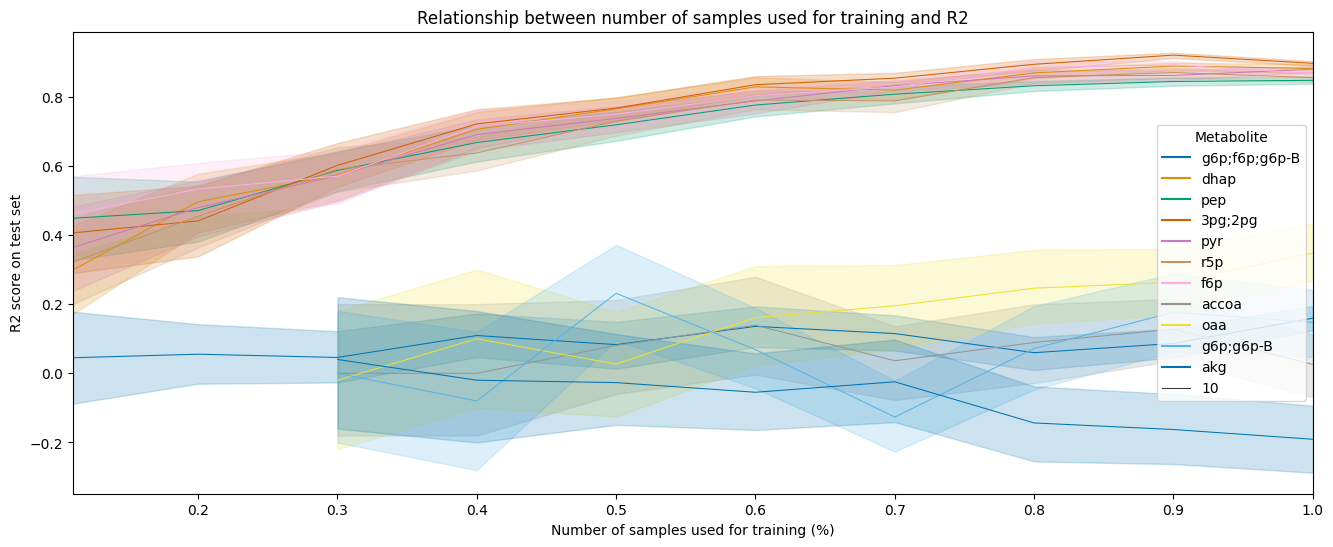

In [111]:
plt.figure(figsize=(16,6))
g = sns.lineplot(
    data=test_throttle_df,
    x='throttle',
    y='r2',
    hue='metabolite_id',
    palette='colorblind',
    size=10,
)
g.set(xlim=(0.1, 9.0), xlabel='Number of samples used for training (%)', ylabel='R2 score on test set', title='Relationship between number of samples used for training and R2')
plt.legend(loc='center right', title='Metabolite')
plt.savefig('./images/performance/data_throttle_all_strategy.svg', bbox_inches="tight")
plt.savefig('./images/performance/data_throttle_all_strategy.png', bbox_inches="tight")

### Strategy metabolic

In [ ]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0"
paths = glob.glob(dir + "/Strategy.METABOLITE_CENTRIC*.csv")

df = gather_results(paths)
df = fmt_cv_results(df)
df = combine_metabolite_info(df)

test_df = pd.read_csv(
    f'{dir}/best_model_performance.csv',
    index_col=0
)
test_df = test_df.stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1)
test_df = test_df.merge(metabolite_info, left_on='metabolite_id', right_index=True)

test_pred_df = pd.read_json(
    f'{dir}/best_model_prediction_performance.json'
)
test_pred_df = test_pred_df.T.reset_index().set_axis(['metabolite_id', 'y_true', 'y_pred'], axis=1) \
    .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
    .explode(['y_true', 'y_pred'])

cv_fgures = CVFigures(df)
pred_figures = PredictionFigures(test_pred_df)
test_figures = TestFigures(test_df)

In [ ]:
cv_fgures.cv_results()

In [ ]:
test_figures.r2_per_metabolite()

In [ ]:
pred_figures.prediction_per_pathway_all()

In [ ]:
pred_figures.prediction_per_pathway_individual()

In [ ]:
pred_figures.prediction_per_metabolite_individual()

### Strategy ONE VS ALL

#### Model analysis

In [7]:
test_pred_df = pd.read_json(
    f'{dir}/best_model_prediction_performance_Strategy.ONE_VS_ALL.json'
)
test_pred_df = test_pred_df.T.reset_index().drop("index", axis=1).set_axis(['y_true', 'y_pred', 'architecture', 'metabolite_id', 'correlation'], axis=1) \
    .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
    .explode(['y_true', 'y_pred'])

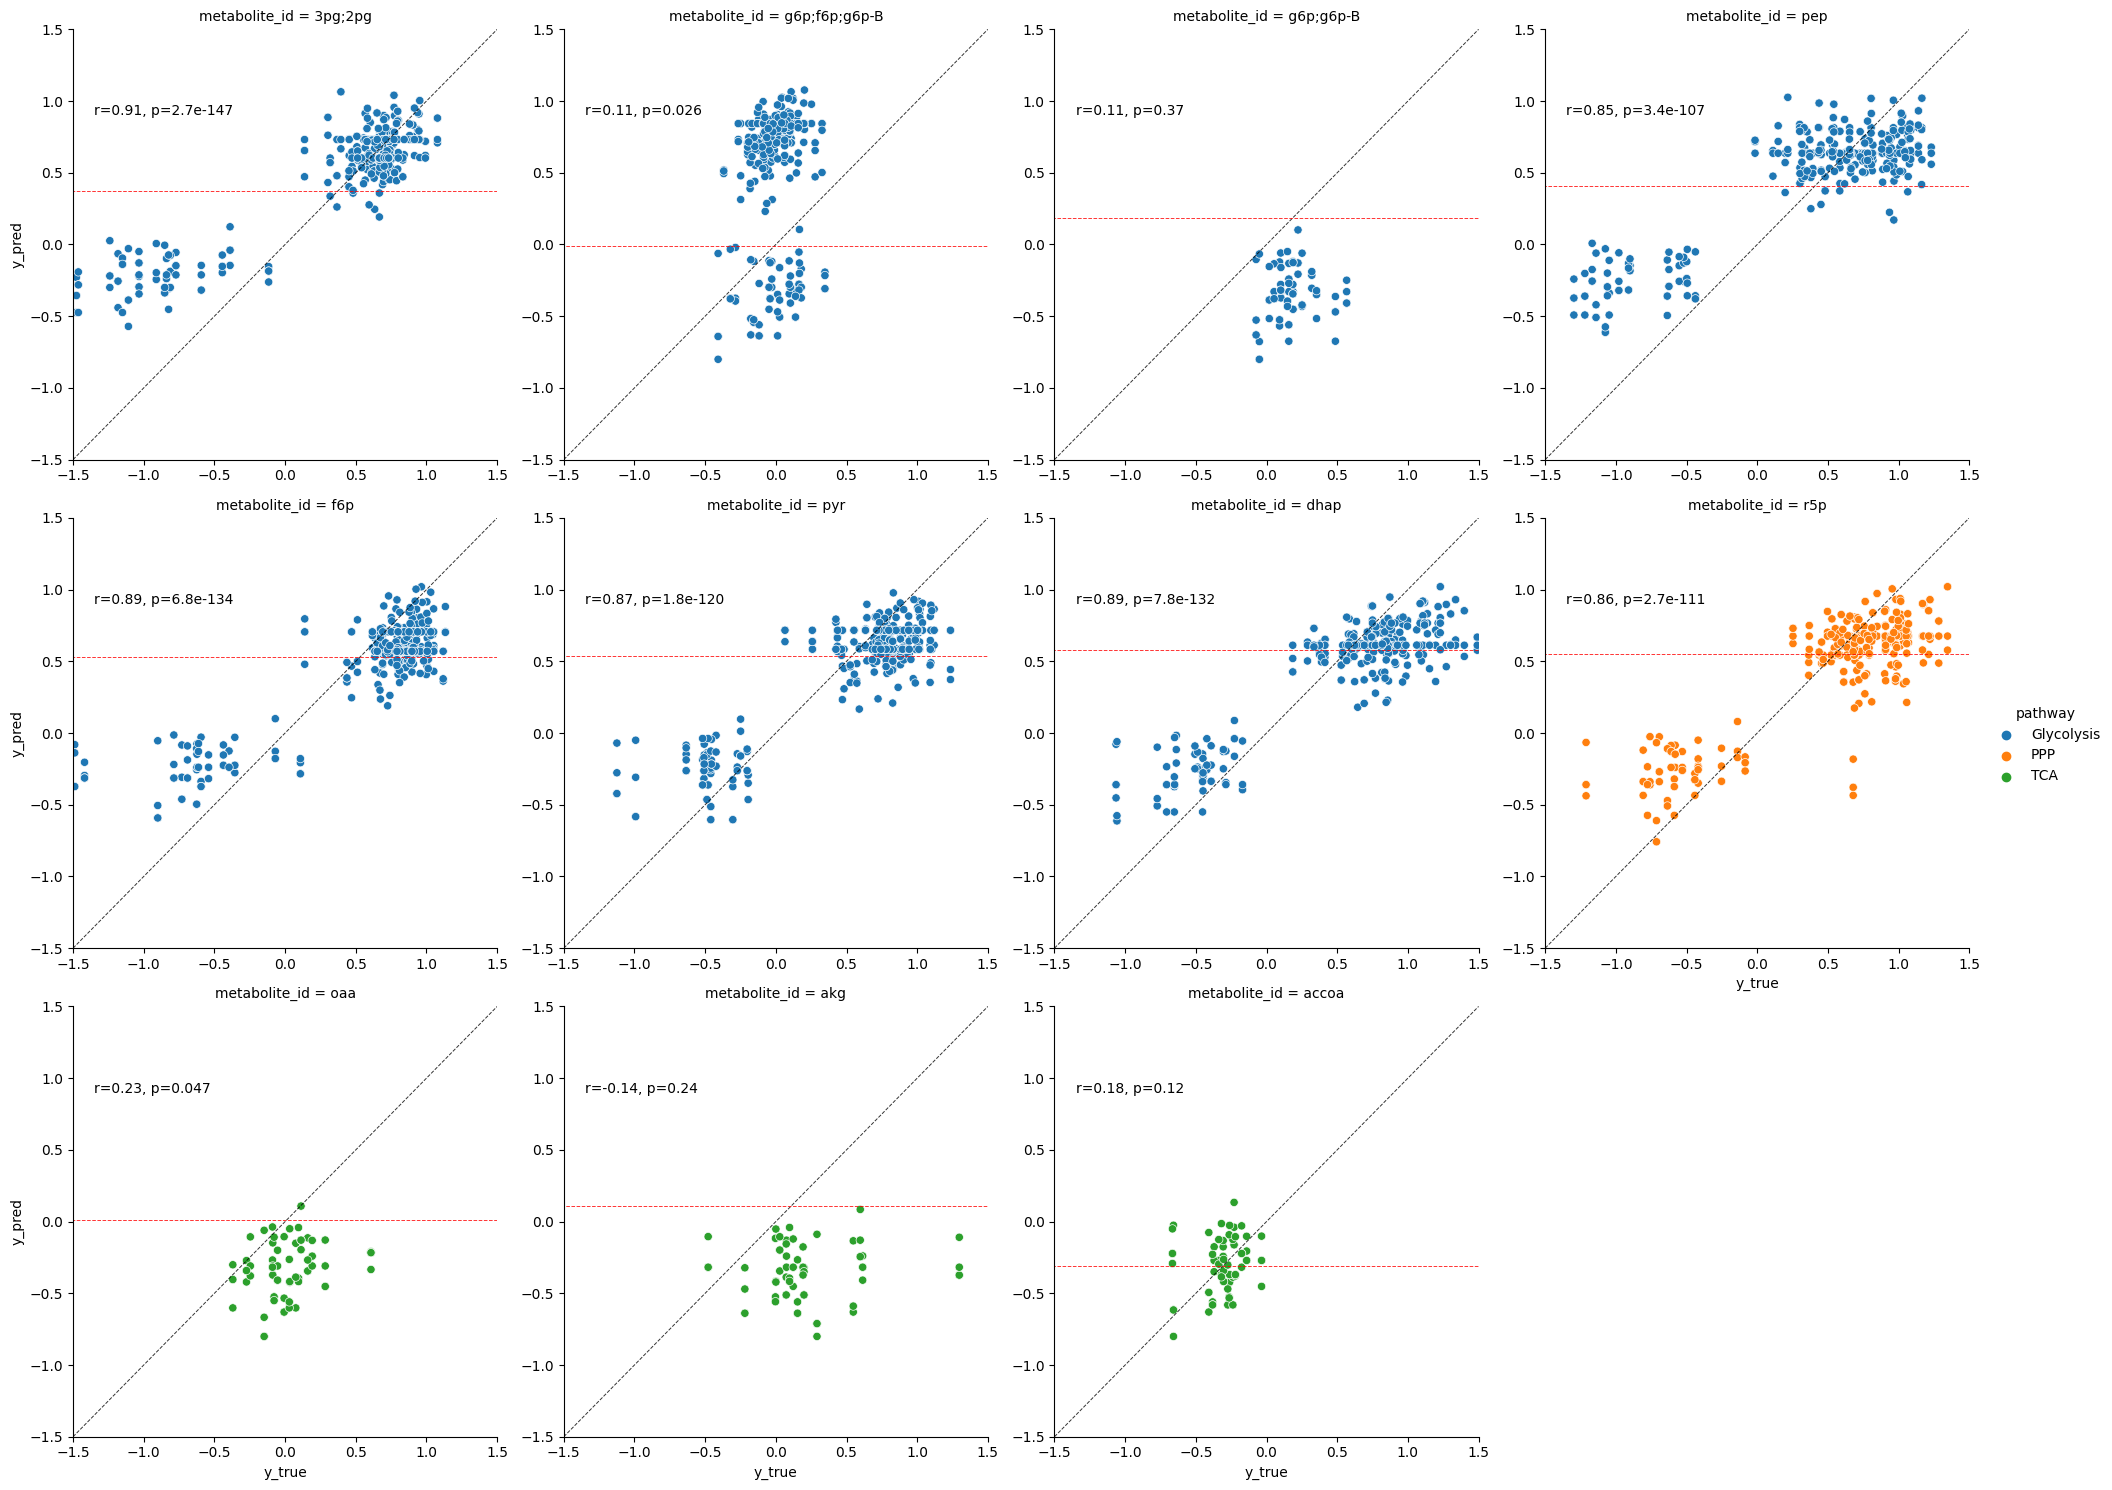

In [9]:
pred_figures = PredictionFigures(test_pred_df)
test_figures = TestFigures(test_df)

pred_figures.prediction_per_metabolite_individual()

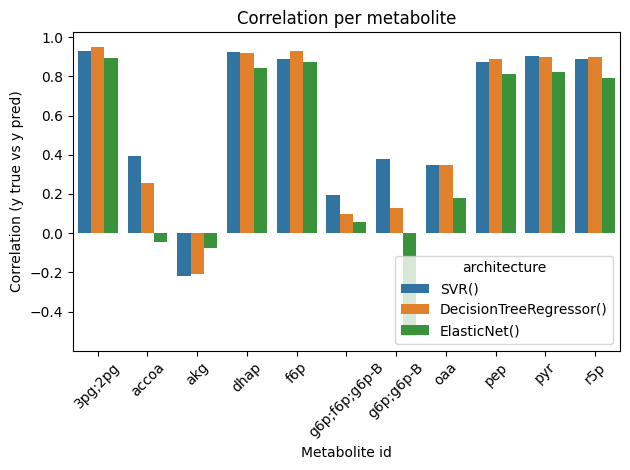

In [10]:
_df = test_pred_df[test_pred_df['architecture'] != 'all']

g = sns.barplot(
    data=_df,
    x='metabolite_id',
    y='correlation',
    hue='architecture'
)
g.axes.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Correlation (y true vs y pred)", title="Correlation per metabolite")
plt.tight_layout()

/tmp/ipykernel_1540/709774156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['error'] = mean_absolute_error(_df['y_true'].values.reshape(1, -1), _df['y_pred'].values.reshape(1, -1), multioutput='raw_values')


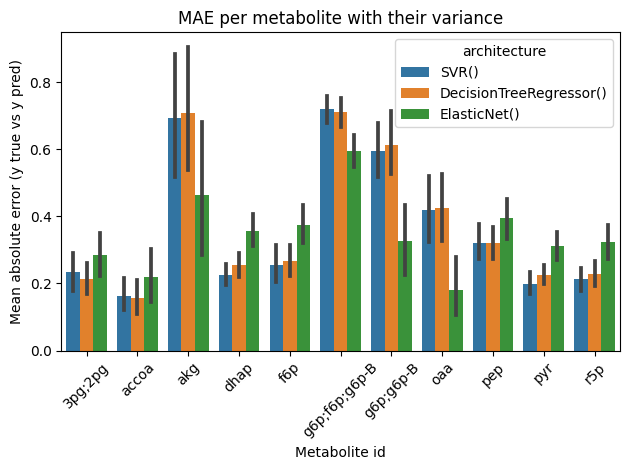

In [11]:
_df = test_pred_df[test_pred_df['architecture'] != 'all']
_df['error'] = mean_absolute_error(_df['y_true'].values.reshape(1, -1), _df['y_pred'].values.reshape(1, -1), multioutput='raw_values')

g = sns.barplot(
    data=_df,
    x='metabolite_id',
    y='error',
    hue='architecture'
)
g.axes.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Mean absolute error (y true vs y pred)", title="MAE per metabolite with their variance")
plt.tight_layout()

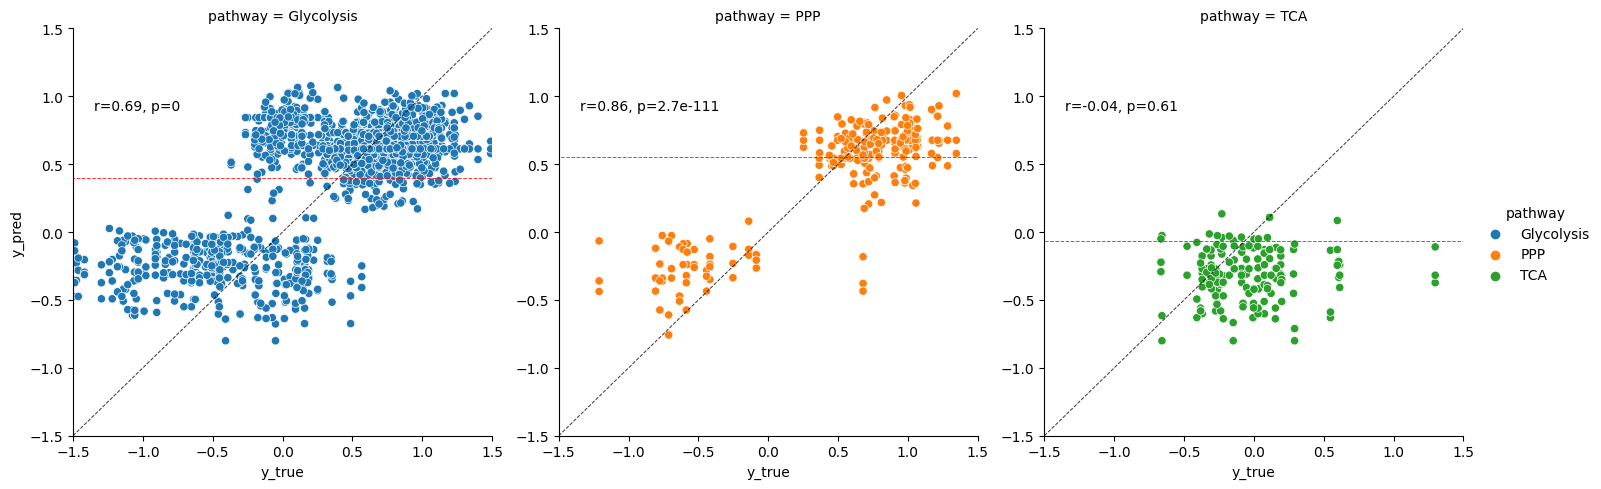

In [12]:
pred_figures.prediction_per_pathway_individual()

## Experiments simple baseline (TIER 1)

In [21]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_1"

test_df_all, test_df_metabolite, test_df_one_vs_all = None, None, None
if os.path.exists(f'{dir}/best_model_performance_Strategy.ALL.csv'):
    test_df_all = pd.read_csv(
        f'{dir}/best_model_performance_Strategy.ALL.csv',
        index_col=0
    )
    test_df_all = test_df_all.stack().to_frame().reset_index(1).set_axis(['metabolite_arch', 'r2'], axis=1)
    test_df_all[['metabolite_id', 'architecture']] = test_df_all['metabolite_arch'].str.split("_", expand=True)
    test_df_all = test_df_all.drop('metabolite_arch', axis=1).merge(metabolite_info, left_on='metabolite_id', right_index=True).assign(strategy='all')

if os.path.exists(f'{dir}/best_model_performance_Strategy.METABOLITE_CENTRIC.csv'):
    test_df_metabolite = pd.read_csv(
        f'{dir}/best_model_performance_Strategy.METABOLITE_CENTRIC.csv',
        index_col=0
    )
    test_df_metabolite = test_df_metabolite.stack().to_frame().reset_index(1).set_axis(['metabolite_arch', 'r2'], axis=1)
    test_df_metabolite[['metabolite_id', 'architecture']] = test_df_metabolite['metabolite_arch'].str.split("_", expand=True)
    test_df_metabolite = test_df_metabolite.drop('metabolite_arch', axis=1).merge(metabolite_info, left_on='metabolite_id', right_index=True).assign(strategy='metabolite')

if os.path.exists(f'{dir}/best_model_performance_Strategy.ONE_VS_ALL.csv'):
    test_df_one_vs_all = pd.read_csv(
        f'{dir}/best_model_performance_Strategy.ONE_VS_ALL.csv',
        index_col=0
    )
    test_df_one_vs_all = test_df_one_vs_all.stack().to_frame().reset_index(1).set_axis(['metabolite_arch', 'r2'], axis=1)
    test_df_one_vs_all[['metabolite_id', 'architecture']] = test_df_one_vs_all['metabolite_arch'].str.split("_", expand=True)
    test_df_one_vs_all = test_df_one_vs_all.drop('metabolite_arch', axis=1).merge(metabolite_info, left_on='metabolite_id', right_index=True).assign(strategy='one_vs_all')
    # test_df_metabolite = test_df_metabolite.merge(metabolite_info, left_on='metabolite_id', right_index=True).assign(strategy='metabolite')

test_df = pd.concat([test_df_all, test_df_metabolite, test_df_one_vs_all], axis=0)
test_df = test_df[test_df['architecture'] == 'all']
test_figures = TestFigures(test_df)

In [22]:
test_df_metabolite

In [23]:
test_df

,r2,metabolite_id,architecture,official_name,kegg_id,pathway,method,Order,strategy
0,0.900675,pyr,all,Pyruvate,C00022,Glycolysis,TCA,8,all
0,0.220567,g6p;f6p;g6p-B,all,D-Glucose 6-phosphate;D-Fructose 6-phosphate;b...,C00092;C00085;C01172,Glycolysis,TCA,10,all
0,-0.241732,akg,all,2-Oxoglutarate,C00026,TCA,TCA,4,all
0,0.892518,3pg;2pg,all,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,all
0,-0.067710,g6p;g6p-B,all,D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9,all
0,-0.109297,accoa,all,Acetyl-CoA,C00024,TCA,TCA,1,all
0,0.851243,pep,all,Phosphoenolpyruvate,C00074,Glycolysis,TCA,7,all
0,0.849061,r5p,all,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,all
0,0.882350,dhap,all,Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5,all
0,0.300555,oaa,all,Oxaloacetate,C00036,TCA,TCA,8,all


In [ ]:
g = test_figures.r2_per_tier(plot_args=dict(height=8))
g.set(
    title='Comparison of performance between different strategies on precursor metabolites',
    xlabel='Metabolite id',
    ylabel="R^2 (y true vs y pred)"
)

# plt.tight_layout()
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.png', bbox_inches='tight')
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.svg', bbox_inches='tight')

### Strategy all

In [ ]:
def gather_results_throttle_v2(paths: List[str]):
    throttle_coefficients = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('best_model_performance_Strategy.ALL_throttle').split("__") for path in paths]
    throttle_list = [(throttle, run_id.strip("run")) for throttle, run_id in throttle_coefficients]

    df = pd.concat([
        pd.read_csv(path, index_col=0).stack().to_frame().reset_index(1).set_axis(['metabolite_arch', 'r2'], axis=1).assign(throttle=throttle).assign(run_id=run_id).tail(-1)
        for path, (throttle, run_id) in zip(paths, throttle_list)
    ])

    df[['metabolite_id', 'architecture']] = df['metabolite_arch'].str.split("_", expand=True)
    df = df.drop('metabolite_arch', axis=1)
    return df

In [13]:
dir = "./data/results/experiment_1"

test_pred_df = pd.read_json(
    f'{dir}/best_model_prediction_performance_Strategy.ALL.json'
)
test_pred_df = test_pred_df.T.reset_index().drop("index", axis=1).set_axis(['y_true', 'y_pred', 'architecture', 'metabolite_id', 'correlation'], axis=1) \
    .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
    .explode(['y_true', 'y_pred'])

if len(glob.glob(dir + "/throttle/best_model*Strategy.ALL*_run*.csv")) > 0:
    test_throttle_df = gather_results_throttle_v2(glob.glob(dir + "/throttle/best_model*Strategy.ALL*_run*.csv"))
    test_throttle_df = test_throttle_df.sort_values('throttle').merge(metabolite_info, left_on='metabolite_id', right_index=True).reset_index().drop('index', axis=1)
# test_throttle_df.reset_index().drop('index', axis=1)

if os.path.exists(f'{dir}/explanations/Strategy.ALL_explanation.json'):
    explanation_df = pd.read_json(f'{dir}/explanations/Strategy.ALL_explanation.json').merge(metabolite_info, left_on='metabolite_id', right_index=True)

#### Model Analysis

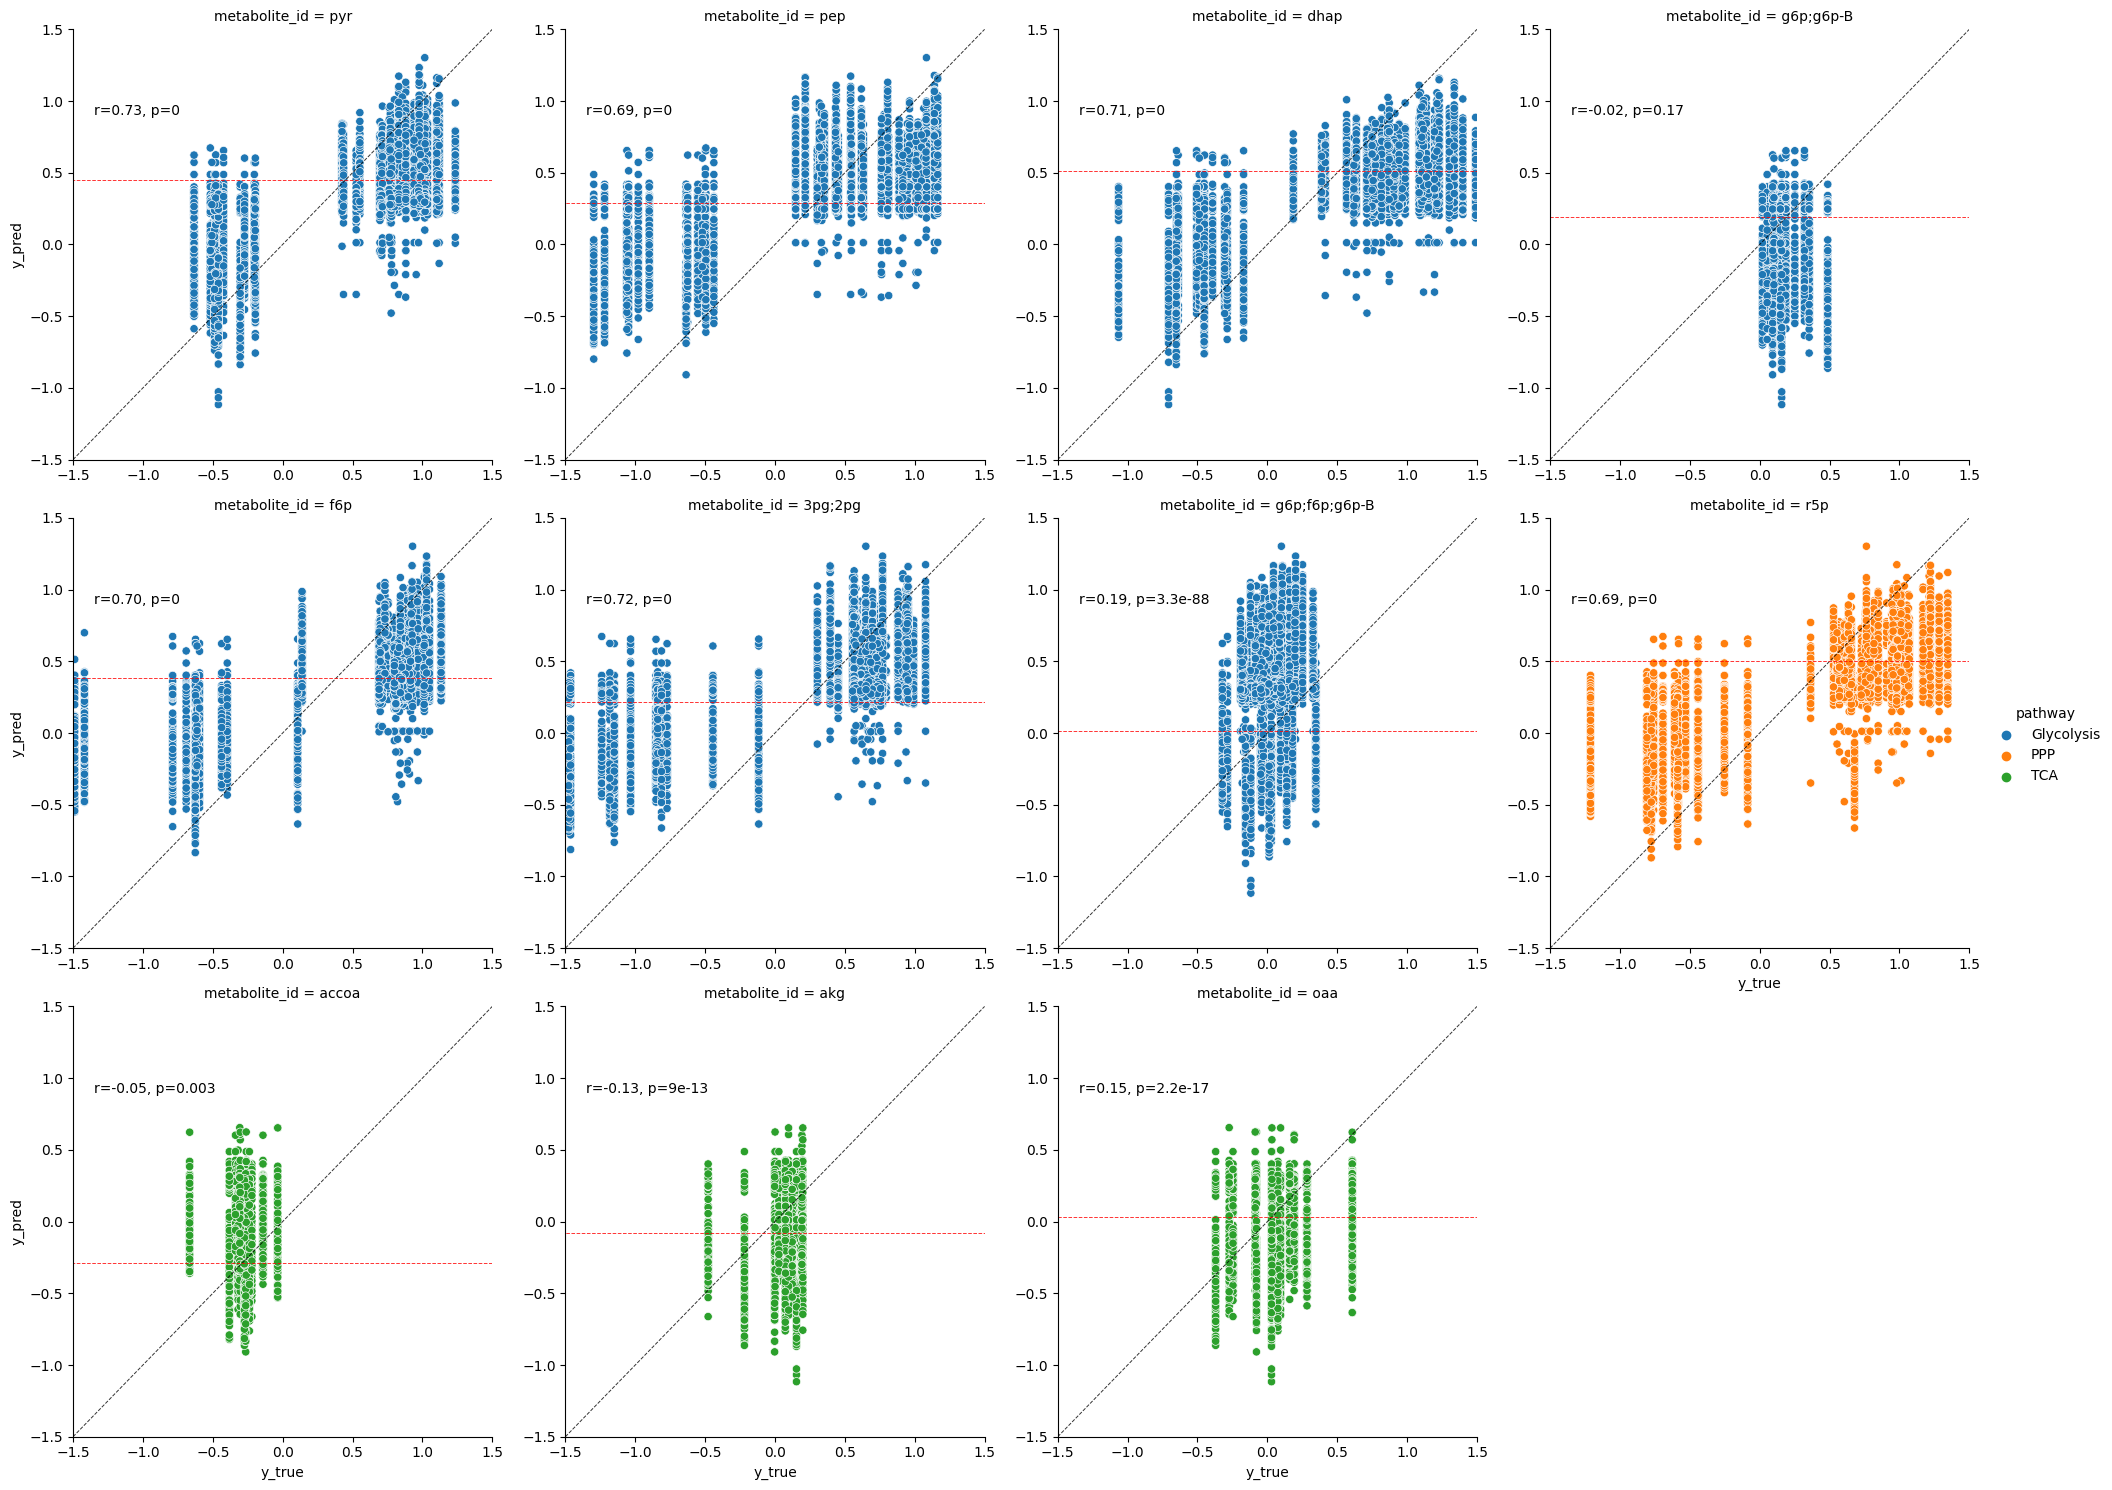

In [25]:
pred_figures = PredictionFigures(test_pred_df)
test_figures = TestFigures(test_df)

pred_figures.prediction_per_metabolite_individual()

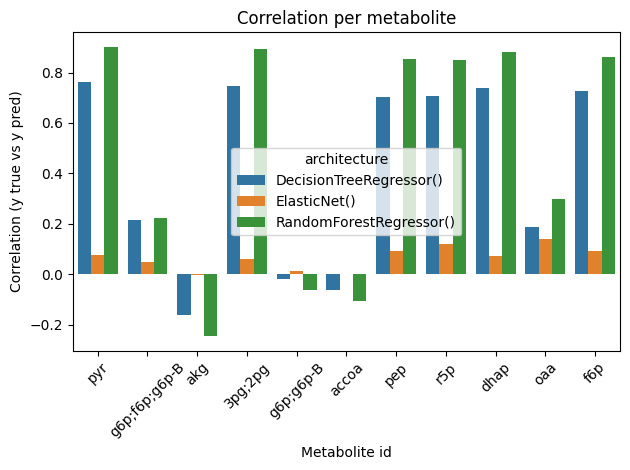

In [26]:
_df = test_pred_df[test_pred_df['architecture'] != 'all']

g = sns.barplot(
    data=_df,
    x='metabolite_id',
    y='correlation',
    hue='architecture'
)
g.axes.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Correlation (y true vs y pred)", title="Correlation per metabolite")
plt.tight_layout()
plt.savefig('./images/correlation_per_metabolite_model_architectures_specific.svg')